In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gudhi as gd
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *
from utils import *
fontsize=16
from tqdm import tqdm

plt.rcParams.update({
    "axes.titlesize": 14,    # Tamaño del título
    "axes.labelsize": fontsize,    # Tamaño de xlabel y ylabel
})

mse_fn = tf.keras.losses.MeanSquaredError()

# Point cloud without noise

## Visualizing the poing cloud that we want to approximate

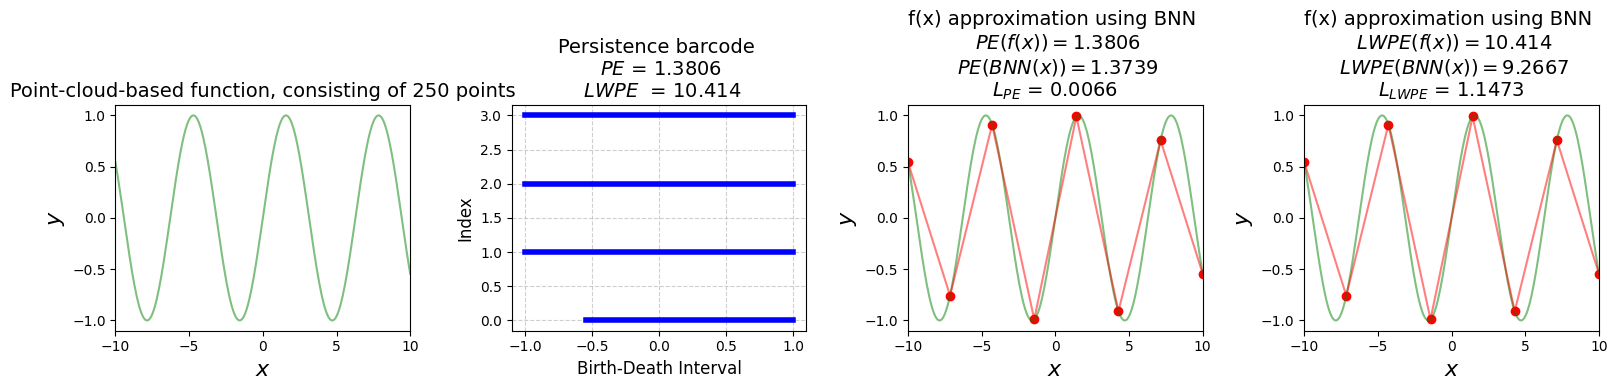

In [2]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # here we define that each element is connected to the next one, since what we have is a line formed by the points of the point cloud
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

num_points_aprox=6
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox+2), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricNetwork(points)

y_aprox = model(tf.expand_dims(x_train,axis=1))

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]
PEAprox=persistent_entropy(dgmAprox)
LWPEAprox=length_weighted_persistent_entropy(dgmAprox)

PEloss = PersistentEntropyLoss()
LWPEloss = LengthWeightedPersistentEntropyLoss()
PEerror = PEloss(dgmRef,dgmAprox)
LWPEerror = LWPEloss(dgmRef,dgmAprox)

lim="lim"
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(PERef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $LWPE$ " + f" = {round(LWPERef.numpy().item(),4)}")
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[2].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[2].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'f(x) approximation using BNN \n $PE(f(x)) = {np.round(PERef.numpy().item(),4)}$\n $PE(BNN(x)) = {np.round(PEAprox.numpy().item(),4)}$ \n' + '$L_{PE}$' + f' = {round(PEerror.numpy().item(),4)}')
axs[3].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[3].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[3].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$y$')
axs[3].set_xlim((domain[0],domain[1]))
axs[3].set_title(f'f(x) approximation using BNN \n $LWPE(f(x)) = {np.round(LWPERef.numpy().item(),4)}$ \n $LWPE(BNN(x)) = {np.round(LWPEAprox.numpy().item(),4)}$ \n' + '$L_{LWPE}$' + f' = {round(LWPEerror.numpy().item(),4)}')
fig.tight_layout()
plt.savefig('figures/WithoutNoiseUnknownFunction.png', dpi=300, bbox_inches='tight')
plt.show()

An illustrative example of calculating persistence entropy and persistence entropy with modification because we want to find the points to approximate an Point-cloud-based function well so its important to get a similar persistent entropy and also the lengths of the bars.

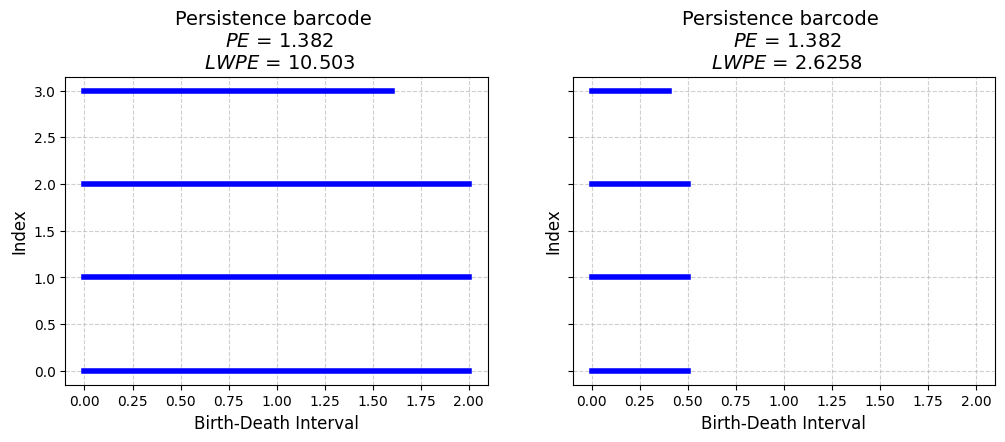

In [3]:
dgmA = np.array([[0,2],[0,2],[0,2],[0,1.6]])
dgmB = np.array([[0,0.5],[0,0.5],[0,0.5],[0,0.4]])
PE_A = persistent_entropy(dgmA)
LWPE_A = length_weighted_persistent_entropy(dgmA)
PE_B = persistent_entropy(dgmB)
LWPE_B = length_weighted_persistent_entropy(dgmB)

fig, axs = plt.subplots(1, 2, figsize=(12, 4),sharex=True,sharey=True)
plot_persistent_barcode(dgmA,ax=axs[0])
axs[0].set_title(axs[0].get_title() + f" \n $PE$ = {round(PE_A.numpy().item(),4)}" + "\n $LWPE$ " + f"= {round(LWPE_A.numpy().item(),4)}")
plot_persistent_barcode(dgmB,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(PE_B.numpy().item(),4)}" + "\n $LWPE$ " + f"= {round(LWPE_B.numpy().item(),4)}")
plt.show()

As we have seen in the following results of this notebook (Compare_PELoss.ipynb) the loss function using $LWPE$ is better, so from now on we will use it for the calculation of the loss function

## MSE loss

100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


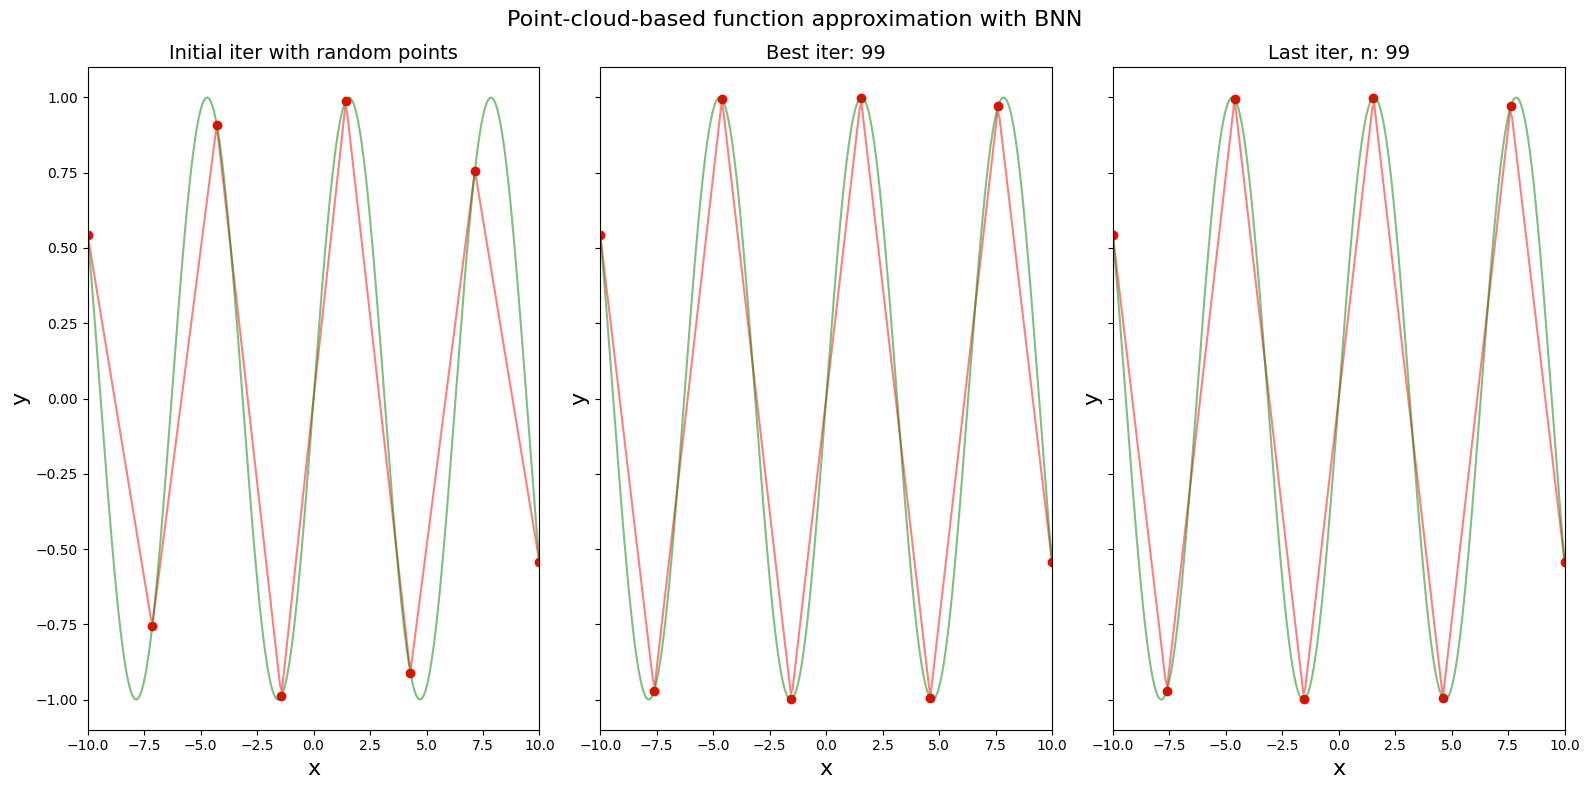

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

num_points_aprox=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox), dtype=tf.float32) ,trainable=True)

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        mseActual = mse_fn(y_train,y_aprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = LengthWeightedPersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasMSE_withoutnoise_goodinit = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_MSELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

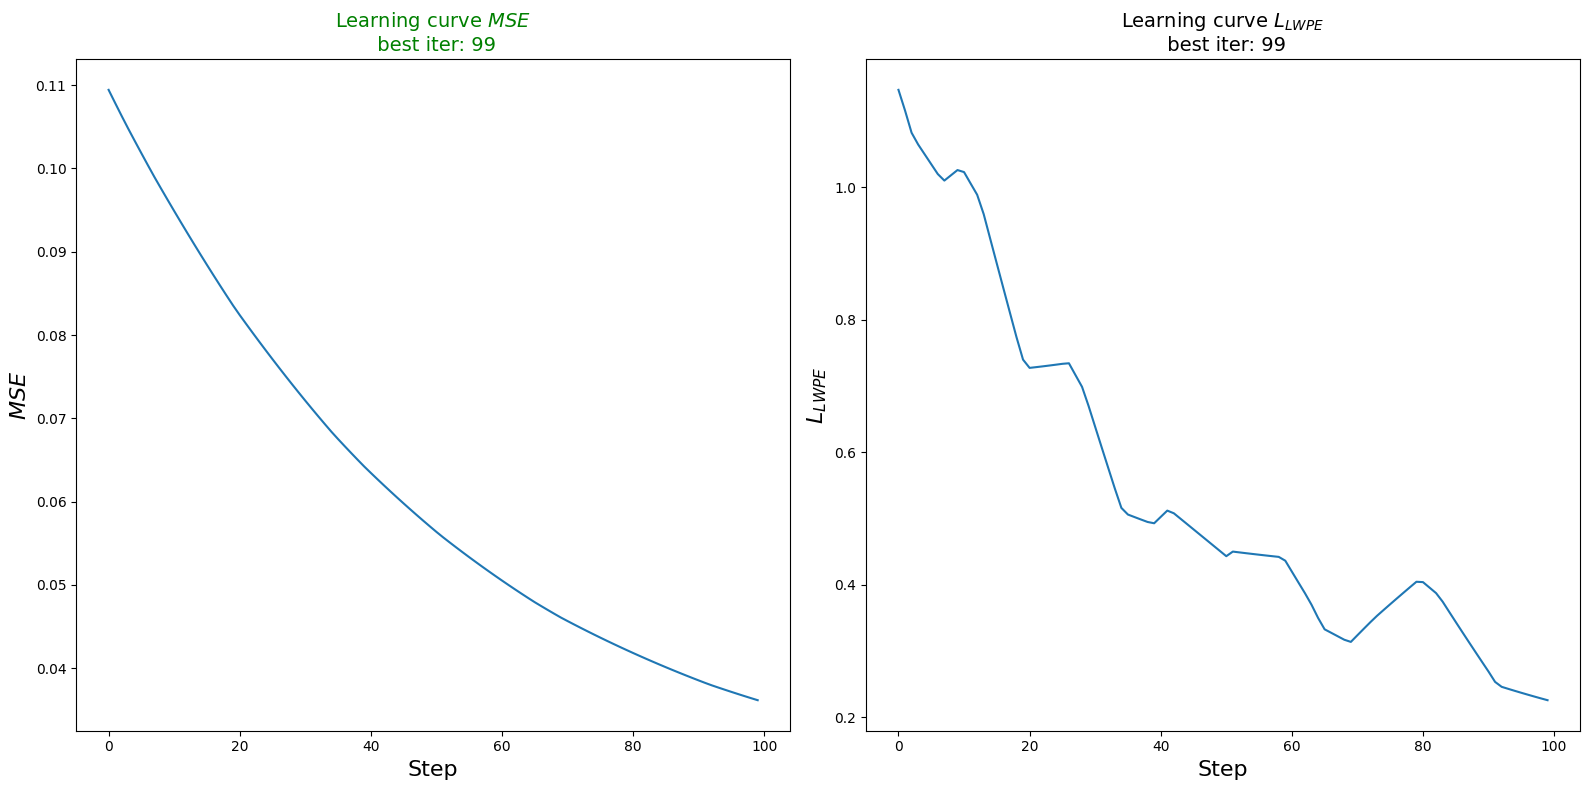

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

What about initializing points very bad and not with equidistant points in this case, because in that way are good point of start

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


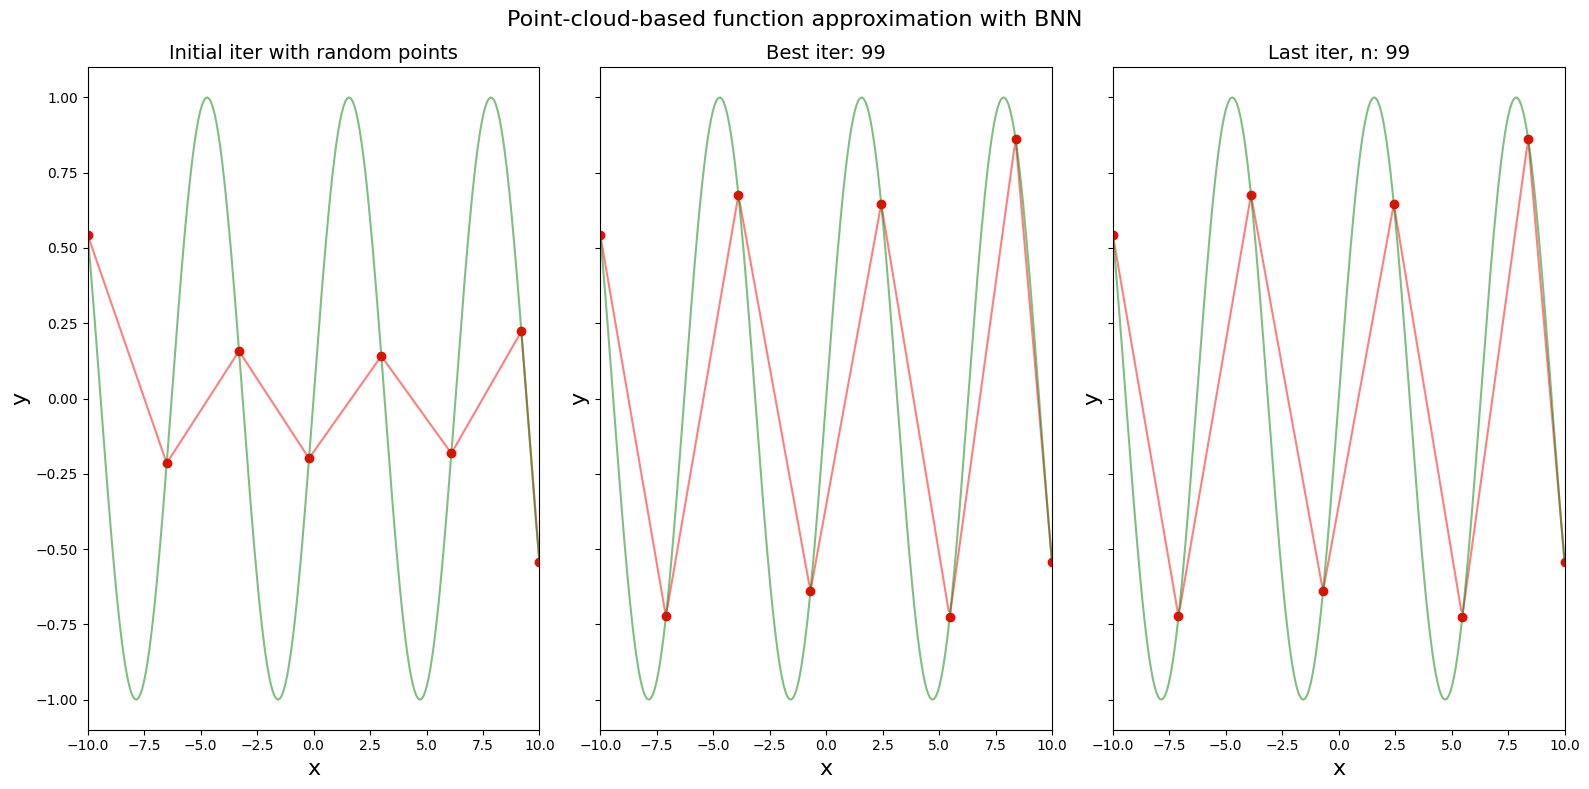

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        mseActual = mse_fn(y_train,y_aprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = LengthWeightedPersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRef,dgmAprox)
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
    
metricasMSE_withoutnoise_badinit = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_MSELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



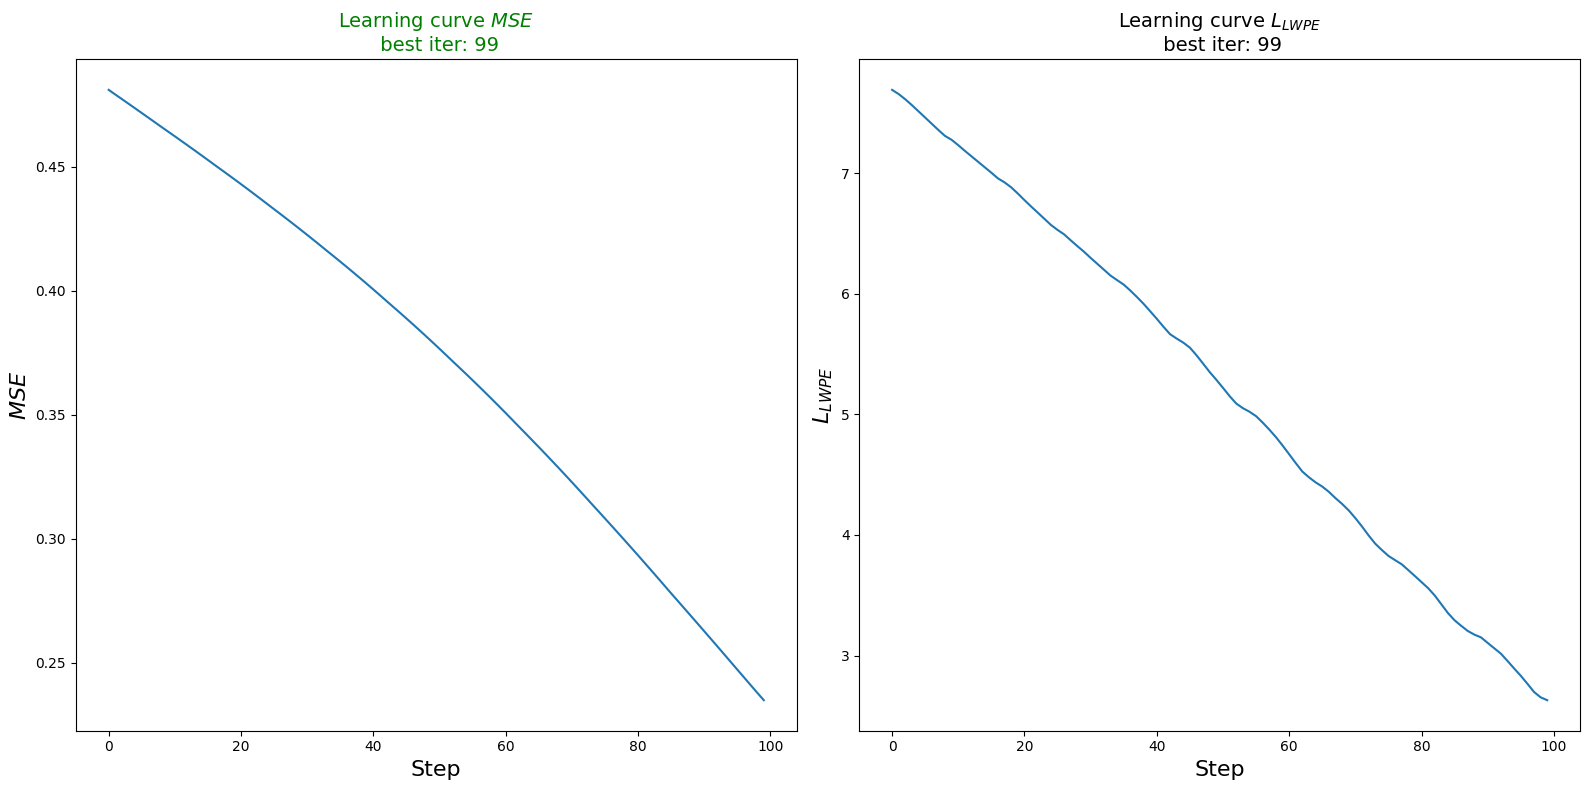

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## $L_{LWPE}$ loss

100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


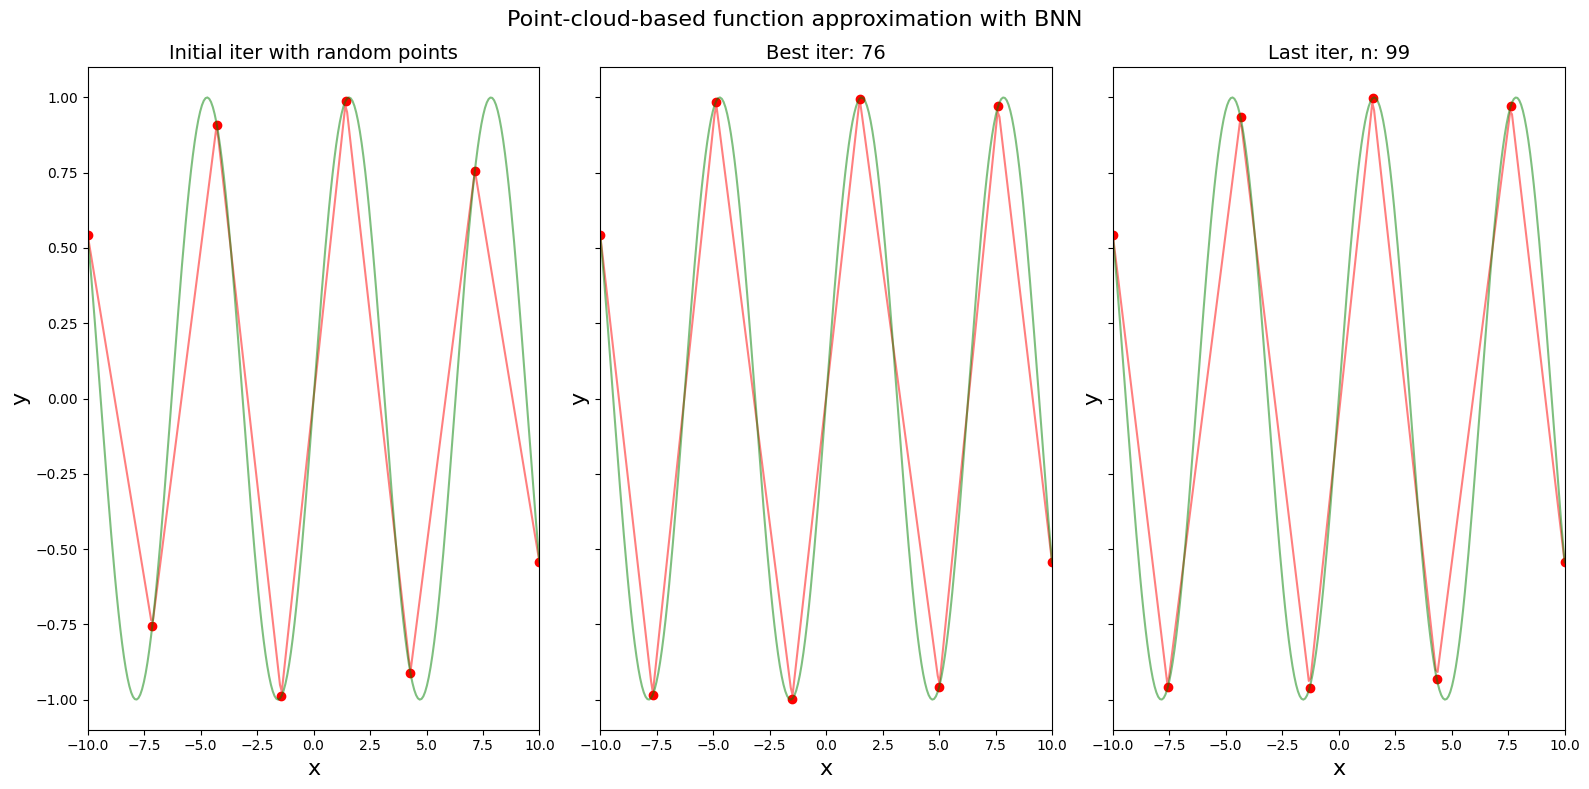

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

num_points_aprox=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox), dtype=tf.float32) ,trainable=True)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points

    mseActual = mse_fn(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasLWPE_withoutnoise_GoodInit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_LWPELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

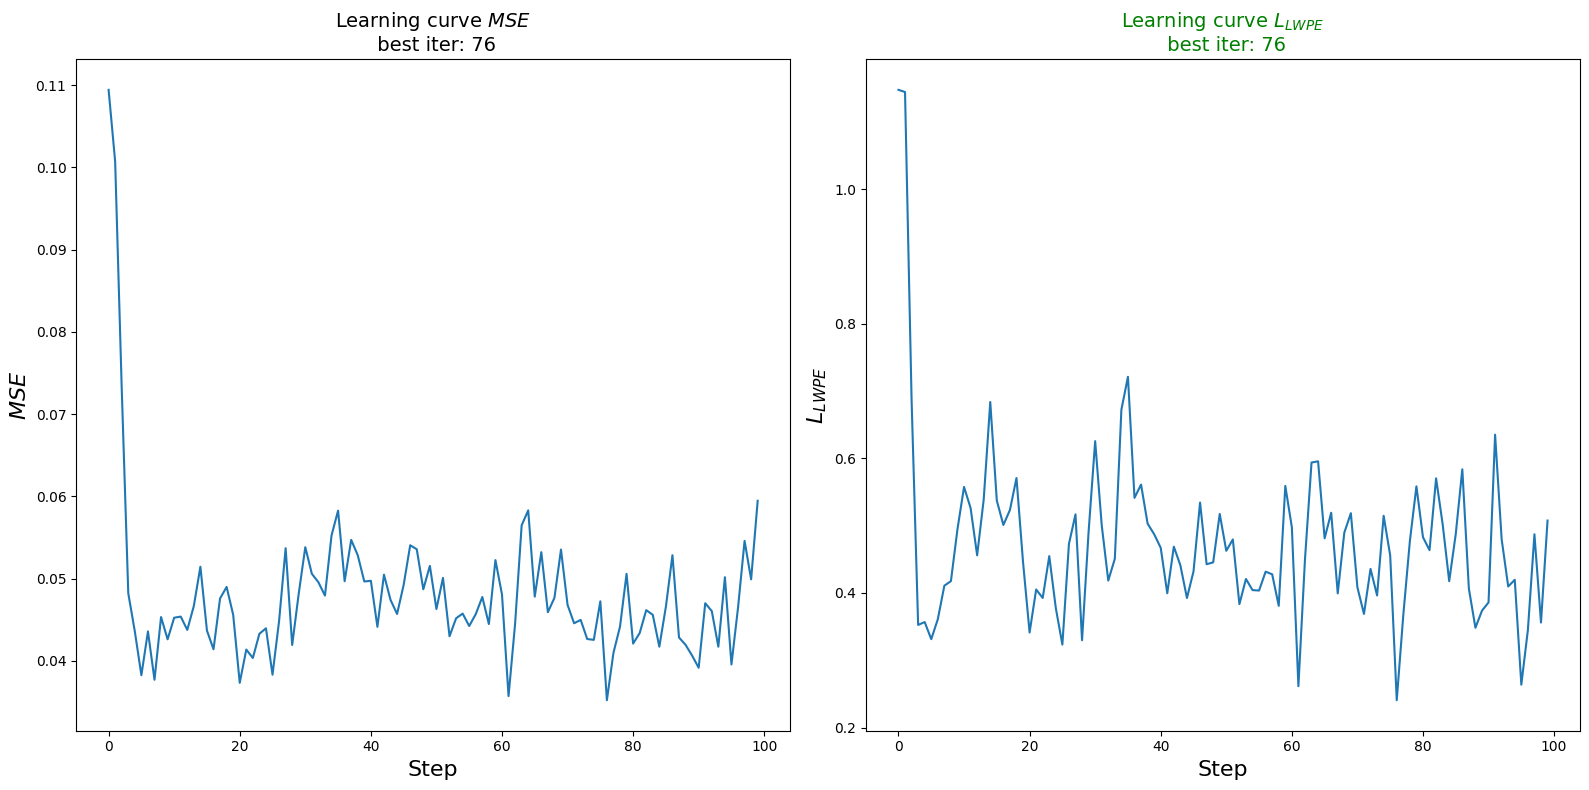

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

What about initializing points very bad and not with equidistant points in this case, because in that way are a good point of start.

100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


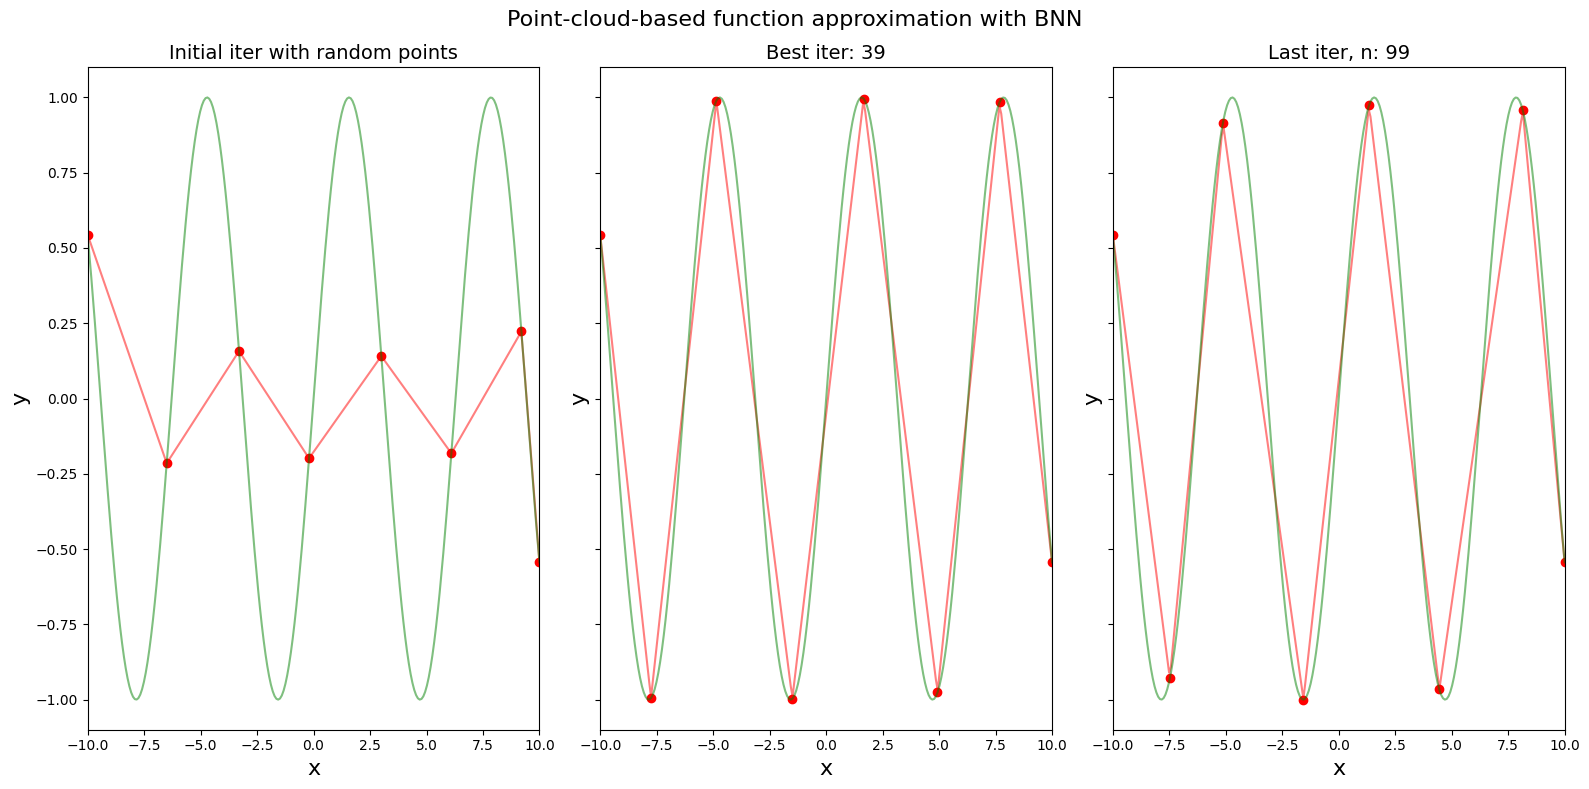

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

num_points_aprox=8
x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRef,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points

    mseActual = mse_fn(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
    
metricasLWPE_withoutnoise_BadInit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithoutNoiseUnknownFunction_LWPELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

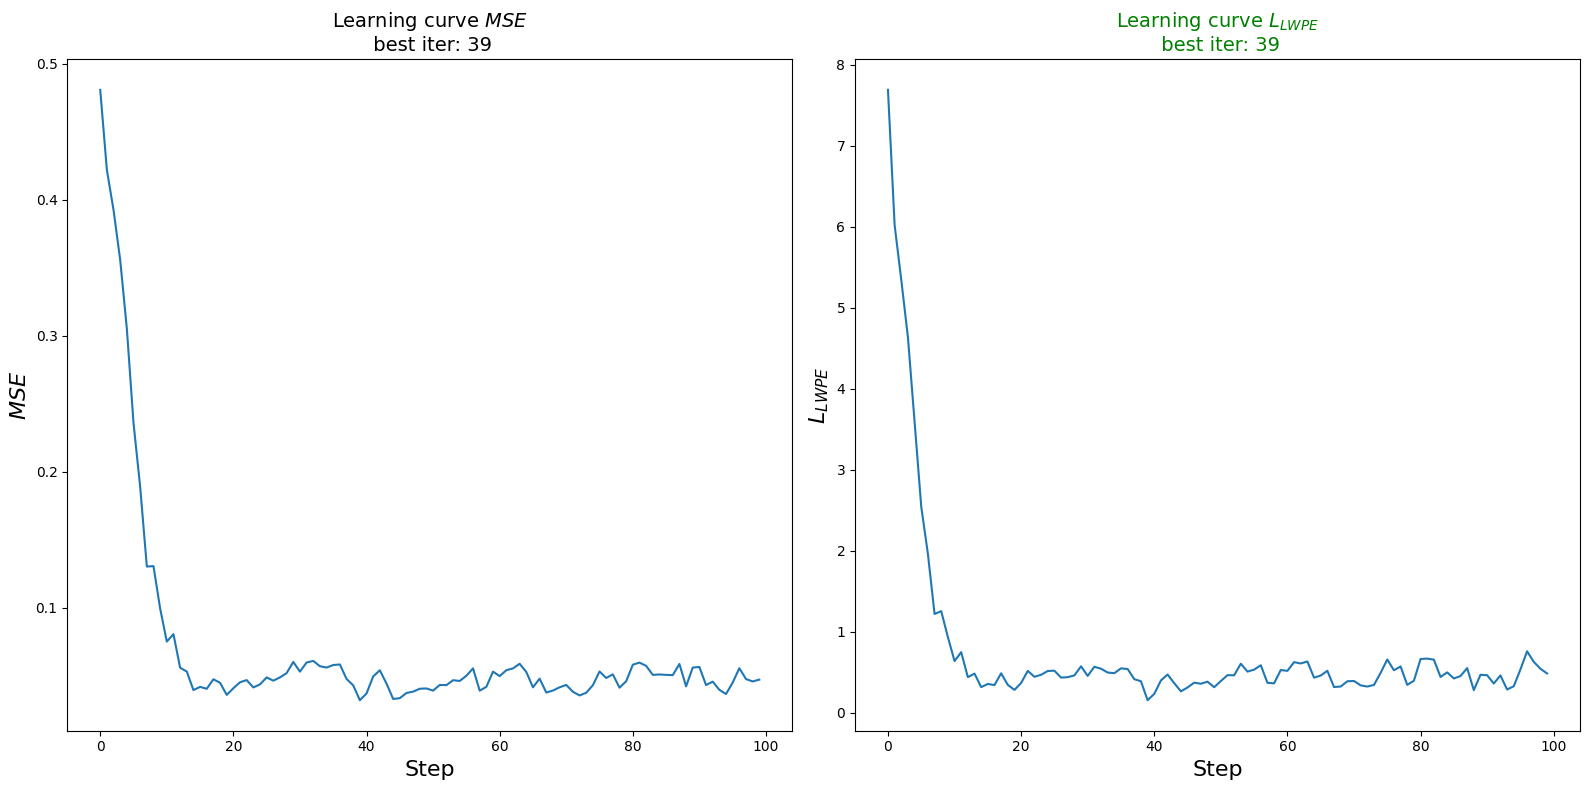

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## Comparing learning curves MSE and $L_{LWPE}$

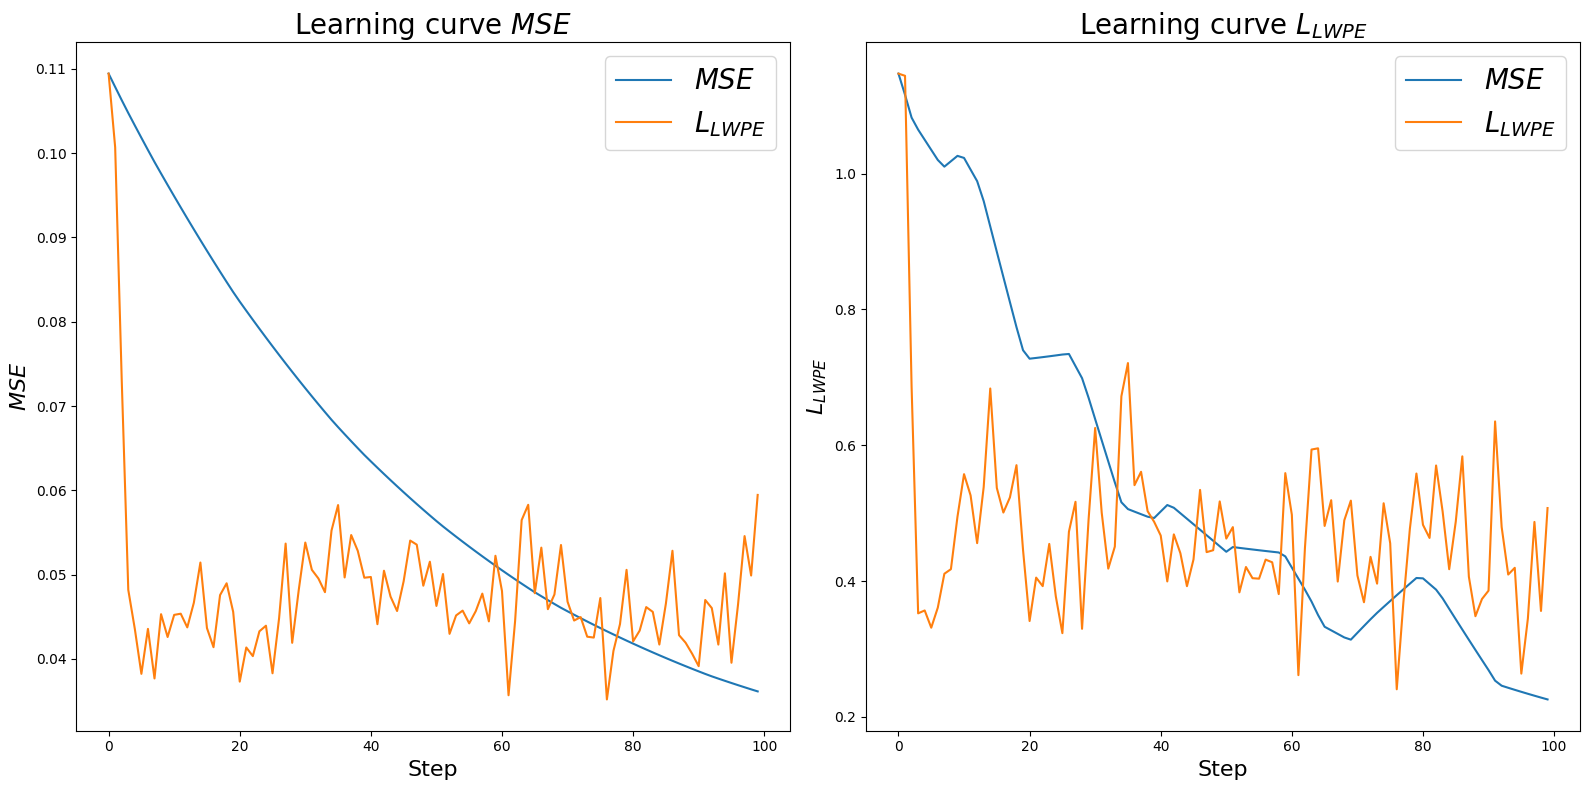

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{LWPE}$"]
for i, metric in enumerate([metricasMSE_withoutnoise_goodinit, metricasLWPE_withoutnoise_GoodInit]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout() 
plt.savefig('figures/LearningCurves_WithoutNoiseUnknownFunction_GoodInit.png', dpi=300, bbox_inches='tight')
plt.show()

Starting with worst points initialization

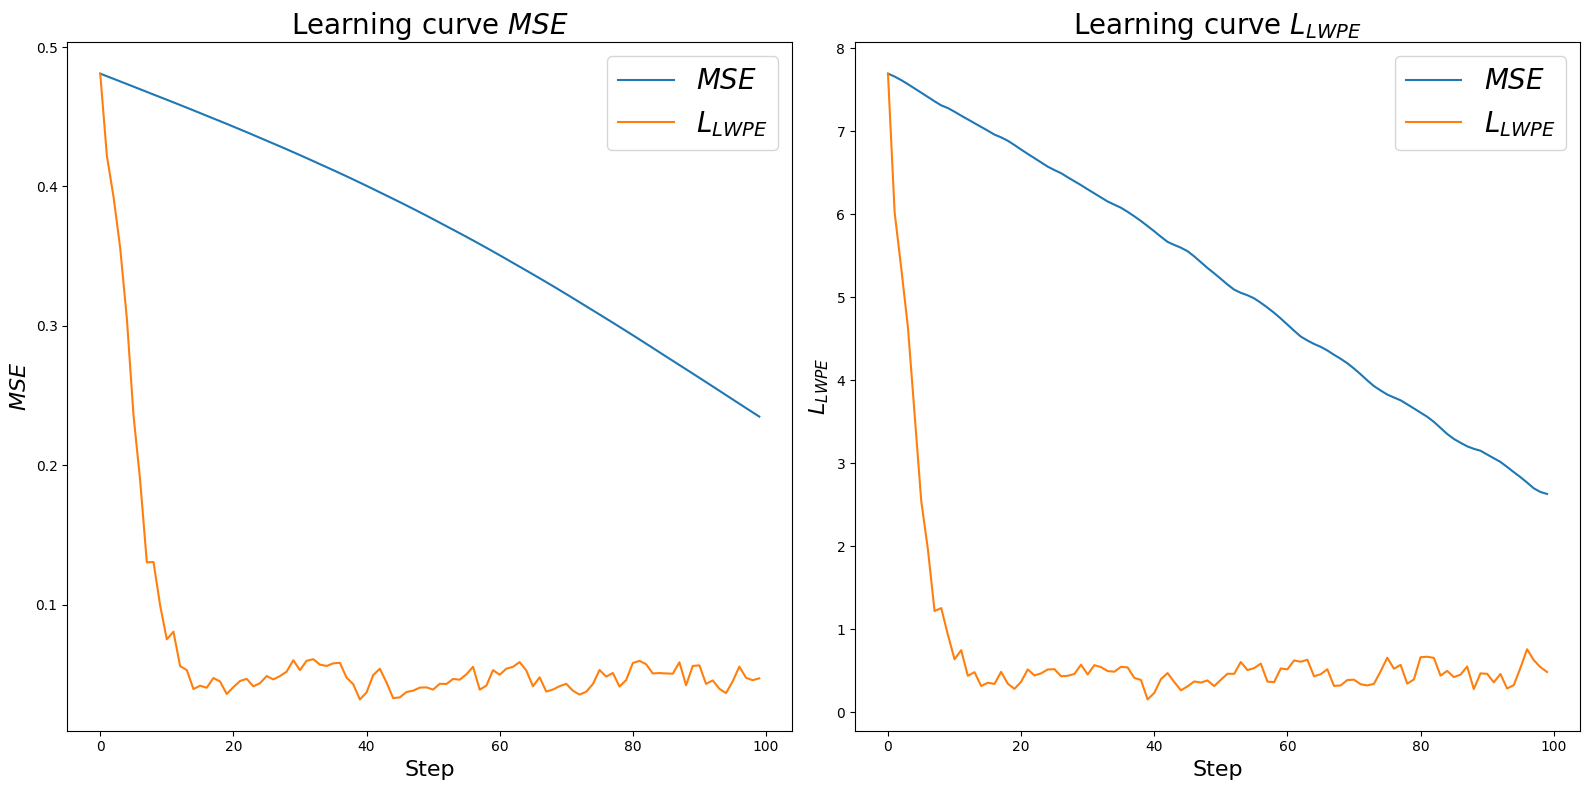

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{LWPE}$"]
for i, metric in enumerate([metricasMSE_withoutnoise_badinit, metricasLWPE_withoutnoise_BadInit]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_WithoutNoiseUnknownFunction_BadInit.png', dpi=300, bbox_inches='tight')
plt.show()

In modern deep learning, Mean Squared PEerror (MSE) is a widely used loss function, primarily due to its simplicity and effectiveness in minimizing numerical discrepancies. However, MSE does not always guarantee a well-structured representation of the underlying data, as it focuses solely on minimizing pointwise differences without considering the global structure.

From the presented learning curves, we observe that models trained with $L_{LWPE}$ exhibit a sharper initial improvement in performance compared to those using only $MSE$. This suggests that $L_{LWPE}$ provides more informative gradients in the early training stages, enabling the model to quickly capture essential structural features in the data. However, in the later stages of training, models trained solely with $L_{LWPE}$ show slightly worse performance than those optimized with $MSE$. This could be due to the fact that $L_{LWPE}$ enforces a stronger structural constraint, which may sometimes conflict with pure numerical optimization.


# Same point cloud with noise

## Visualizing the poing cloud that we want to approximate

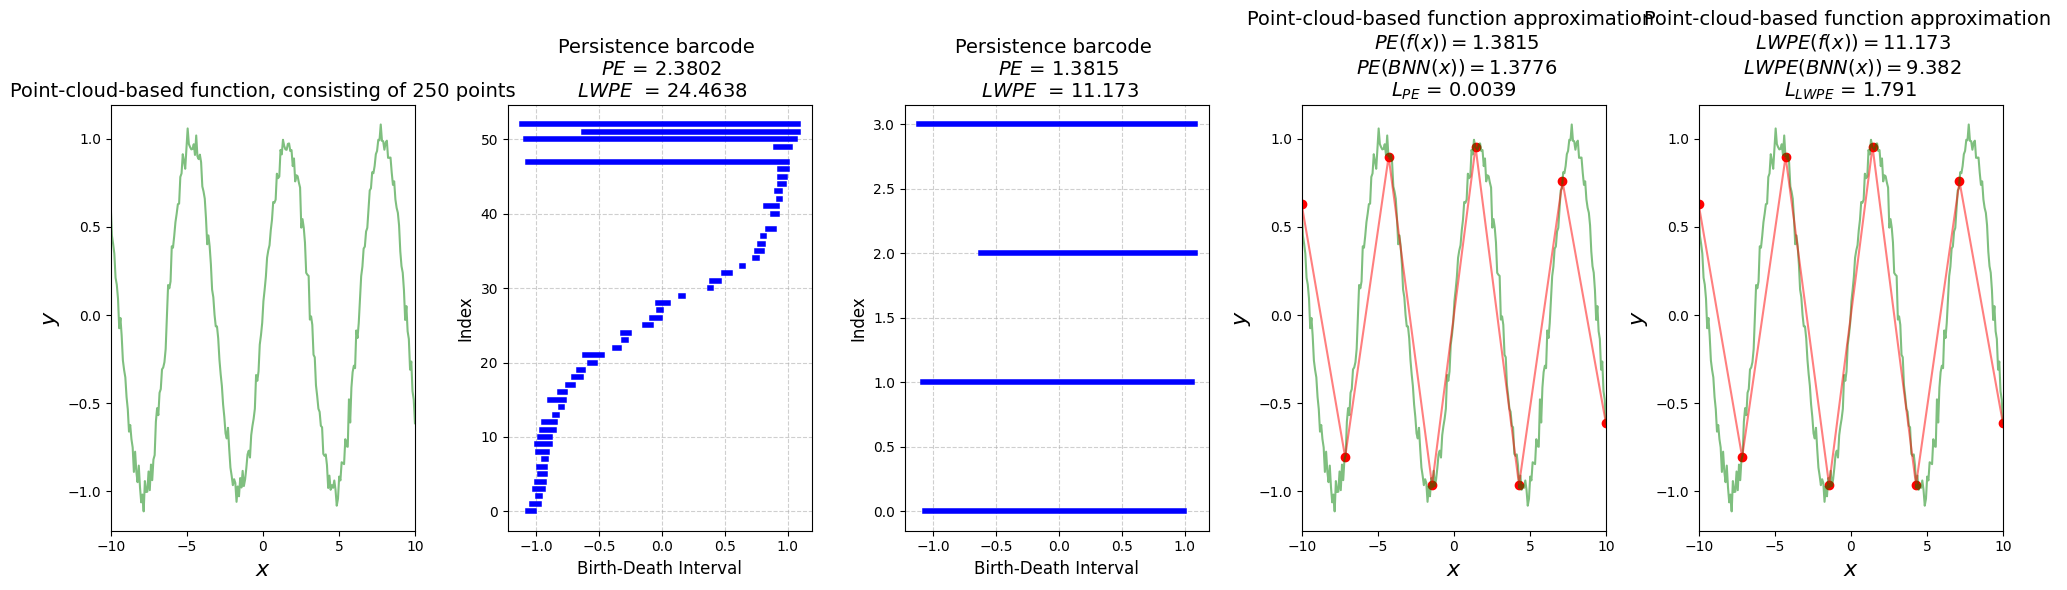

In [14]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)
stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
LWPERefFilt=length_weighted_persistent_entropy(dgmRefFilt)

num_points_aprox=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox), dtype=tf.float32) ,trainable=True)
y_points = interpolation_tf(x_train,y_train, x_points)
points = tf.stack([x_points, y_points], axis=1)

model = BaricentricNetwork(points)

y_aprox = model(tf.expand_dims(x_train,axis=1))

dgmsAprox = layer.call(y_aprox)
dgmAprox = dgmsAprox[0][0]

PEAprox=persistent_entropy(dgmAprox)
LWPEAprox=length_weighted_persistent_entropy(dgmAprox)

PEloss = PersistentEntropyLoss()
LWPEloss = LengthWeightedPersistentEntropyLoss()
PEerror = PEloss(dgmRefFilt,dgmAprox)
LWPEerror = LWPEloss(dgmRefFilt,dgmAprox)

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].plot(x_train, y_train,"g-", alpha=0.5)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$y$')
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Point-cloud-based function, consisting of 250 points')
plot_persistent_barcode(dgmRef,ax=axs[1])
axs[1].set_title(axs[1].get_title() + f" \n $PE$ = {round(PERef.numpy().item(),4)}")
axs[1].set_title(axs[1].get_title() + " \n $LWPE$ " + f" = {round(LWPERef.numpy().item(),4)}")
plot_persistent_barcode(dgmRefFilt,ax=axs[2])
axs[2].set_title(axs[2].get_title() + f" \n $PE$ = {round(PERefFilt.numpy().item(),4)}")
axs[2].set_title(axs[2].get_title() + " \n $LWPE$ " + f" = {round(LWPERefFilt.numpy().item(),4)}")
axs[3].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[3].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[3].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[3].set_xlabel('$x$')
axs[3].set_ylabel('$y$')
axs[3].set_xlim((domain[0],domain[1]))
axs[3].set_title(f'Point-cloud-based function approximation \n $PE(f(x)) = {np.round(PERefFilt.numpy().item(),4)}$\n $PE(BNN(x)) = {np.round(PEAprox.numpy().item(),4)}$ \n' + '$L_{PE}$' + f' = {round(PEerror.numpy().item(),4)}')
axs[4].plot(x_train, y_train, 'g-', label=f'$f(x)$', alpha=0.5)
axs[4].scatter(x_points, y_points, color="red", label="BNN points creation")
axs[4].plot(x_train, y_aprox, 'r-', label=f'$BNN(x)$', alpha=0.5)
axs[4].set_xlabel('$x$')
axs[4].set_ylabel('$y$')
axs[4].set_xlim((domain[0],domain[1]))
axs[4].set_title(f'Point-cloud-based function approximation \n $LWPE(f(x)) = {np.round(LWPERefFilt.numpy().item(),4)}$ \n $LWPE(BNN(x)) = {np.round(LWPEAprox.numpy().item(),4)}$ \n' + '$L_{LWPE}$' + f' = {round(LWPEerror.numpy().item(),4)}')
fig.tight_layout()
plt.show()

## MSE loss

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


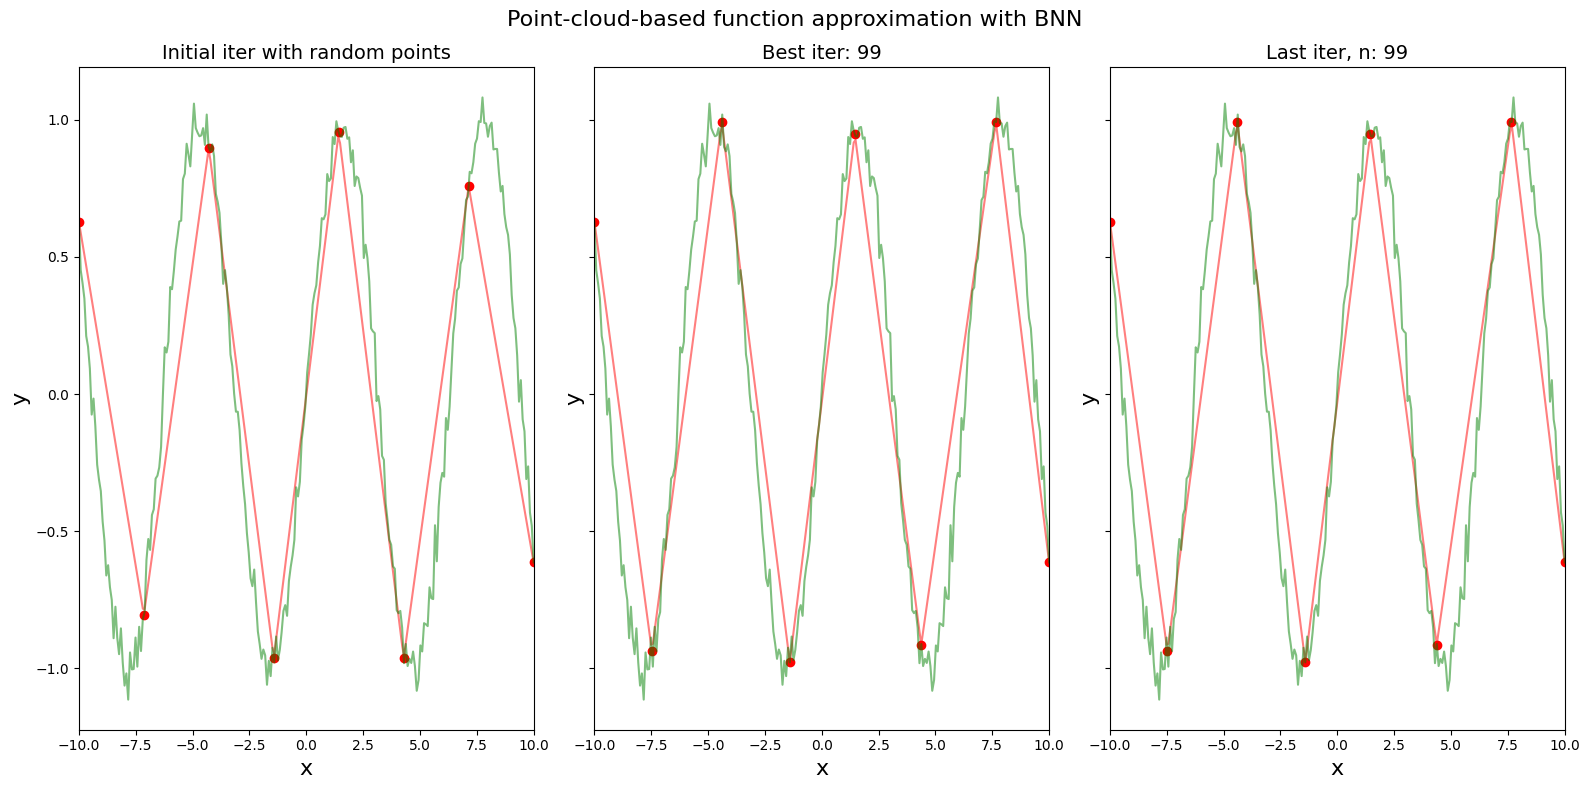

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

num_points_aprox=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox), dtype=tf.float32) ,trainable=True)

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        mseActual = mse_fn(y_train,y_aprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = LengthWeightedPersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
        
metricasMSE_noise_goodinit = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_MSELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

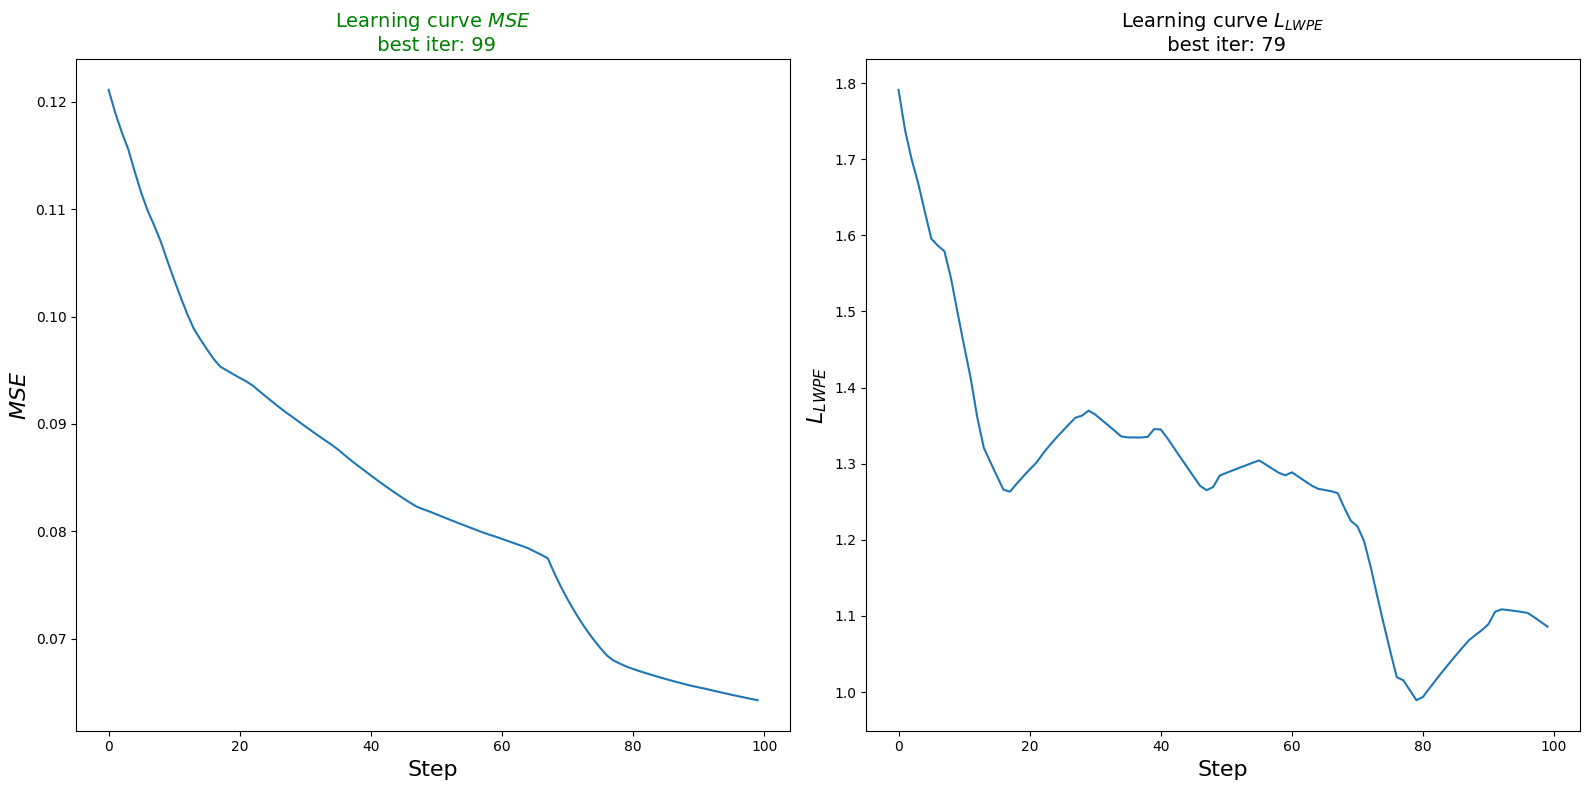

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


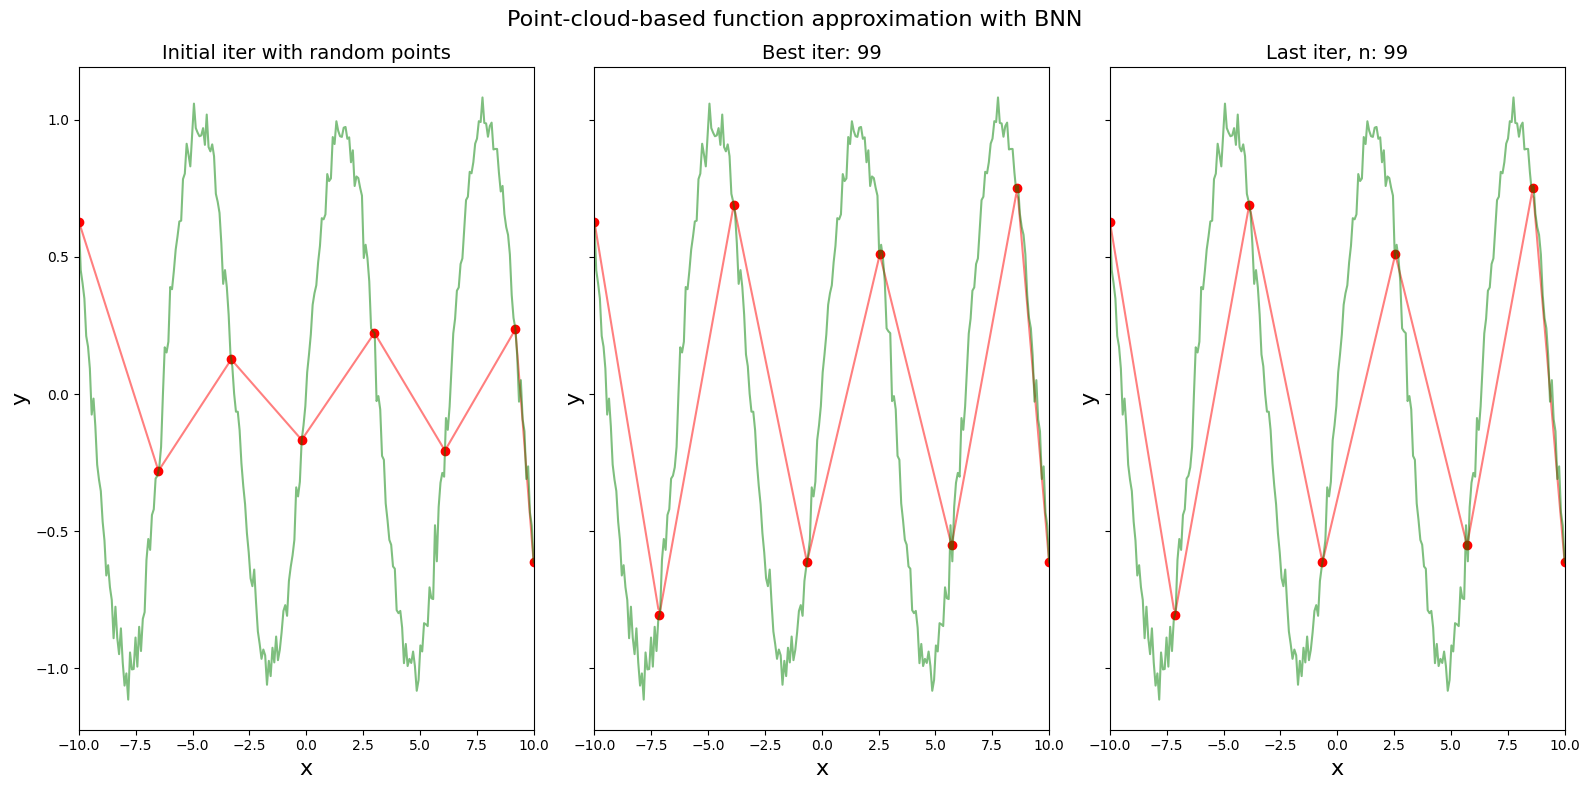

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)
dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]

PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

best_mse = float('inf')  
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        mseActual = mse_fn(y_train,y_aprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)

    lossFunction = LengthWeightedPersistentEntropyLoss()
    entropyLoss = lossFunction(dgmRefFilt,dgmAprox)
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(mseActual,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points
    metricas["$MSE$"].append(mseActual.numpy().item())

    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    if mseActual < best_mse:
        best_mse = mseActual
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        
        
metricasMSE_noise_badinit = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_MSELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

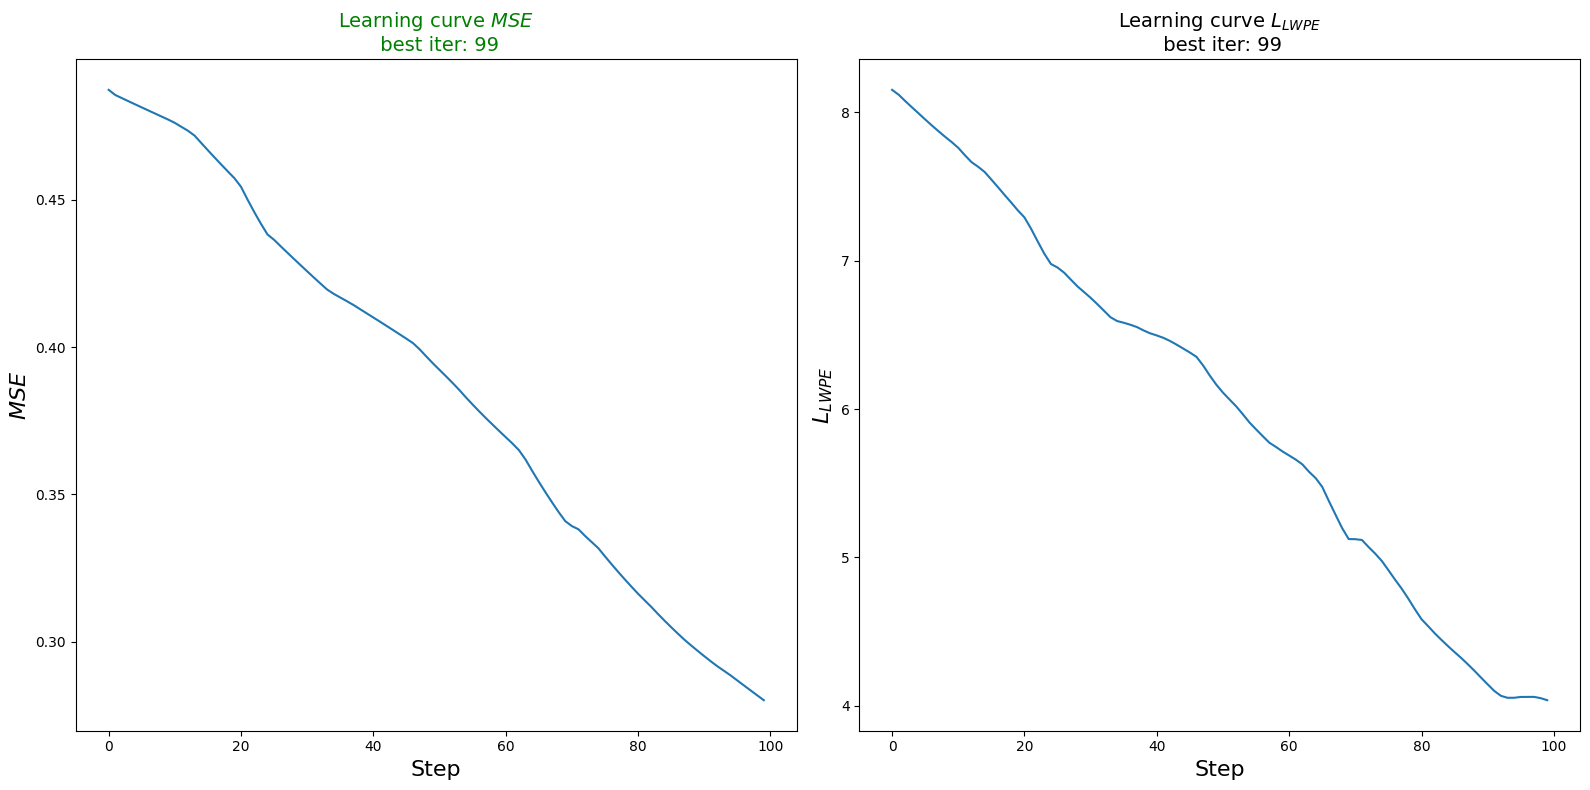

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 0 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## $L_{LWPE}$ loss

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


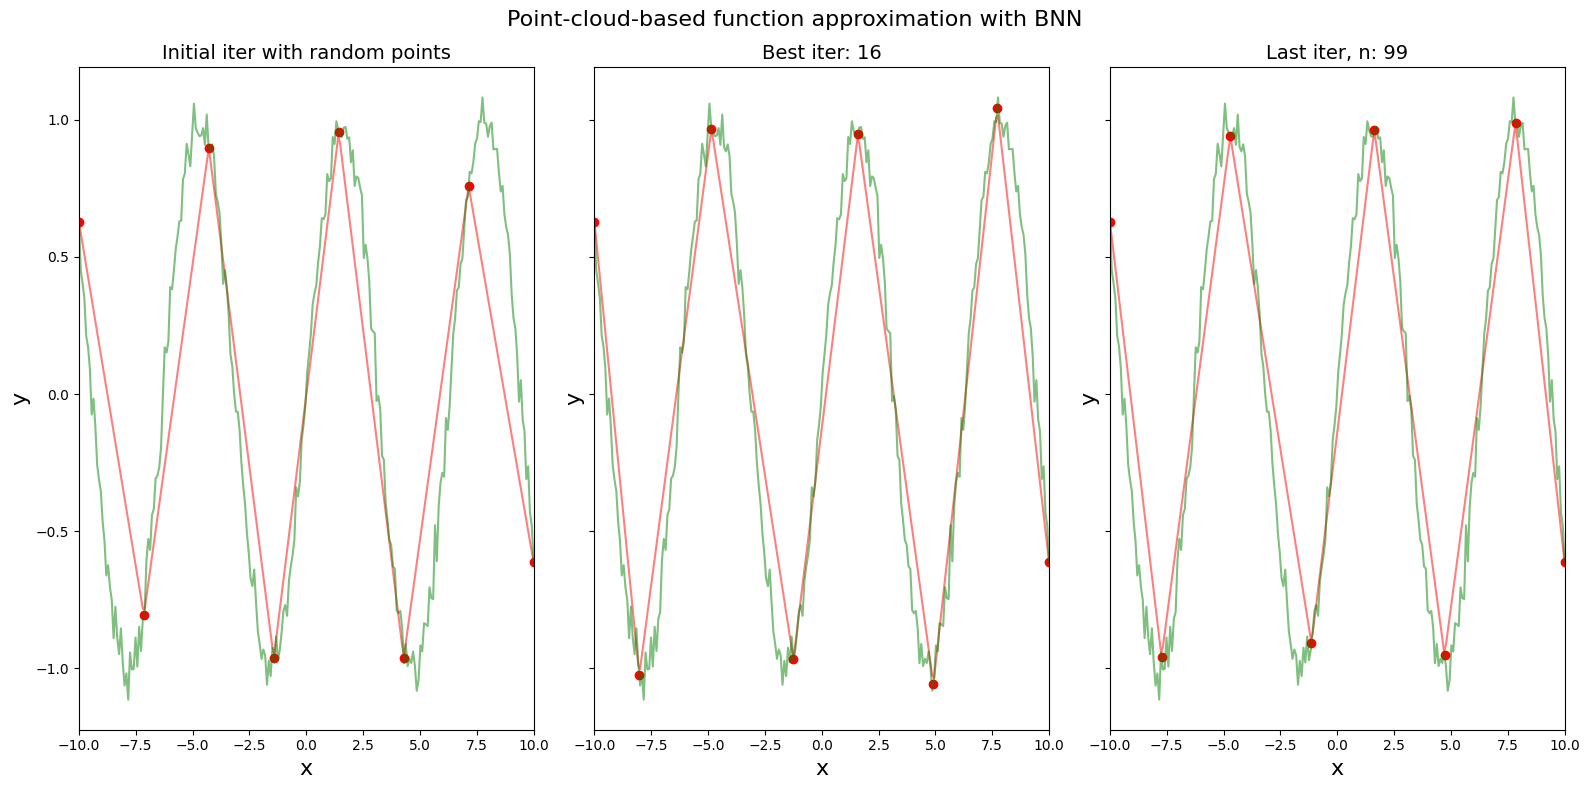

In [ ]:
domain =[-10,10]
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

num_points_aprox=8
x_points = tf.Variable(tf.cast(tf.linspace(domain[0],domain[1],num_points_aprox), dtype=tf.float32) ,trainable=True)

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points

    mseActual = mse_fn(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        

metricasLWPE_noise_goodinit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_LWPELoss_GoodInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

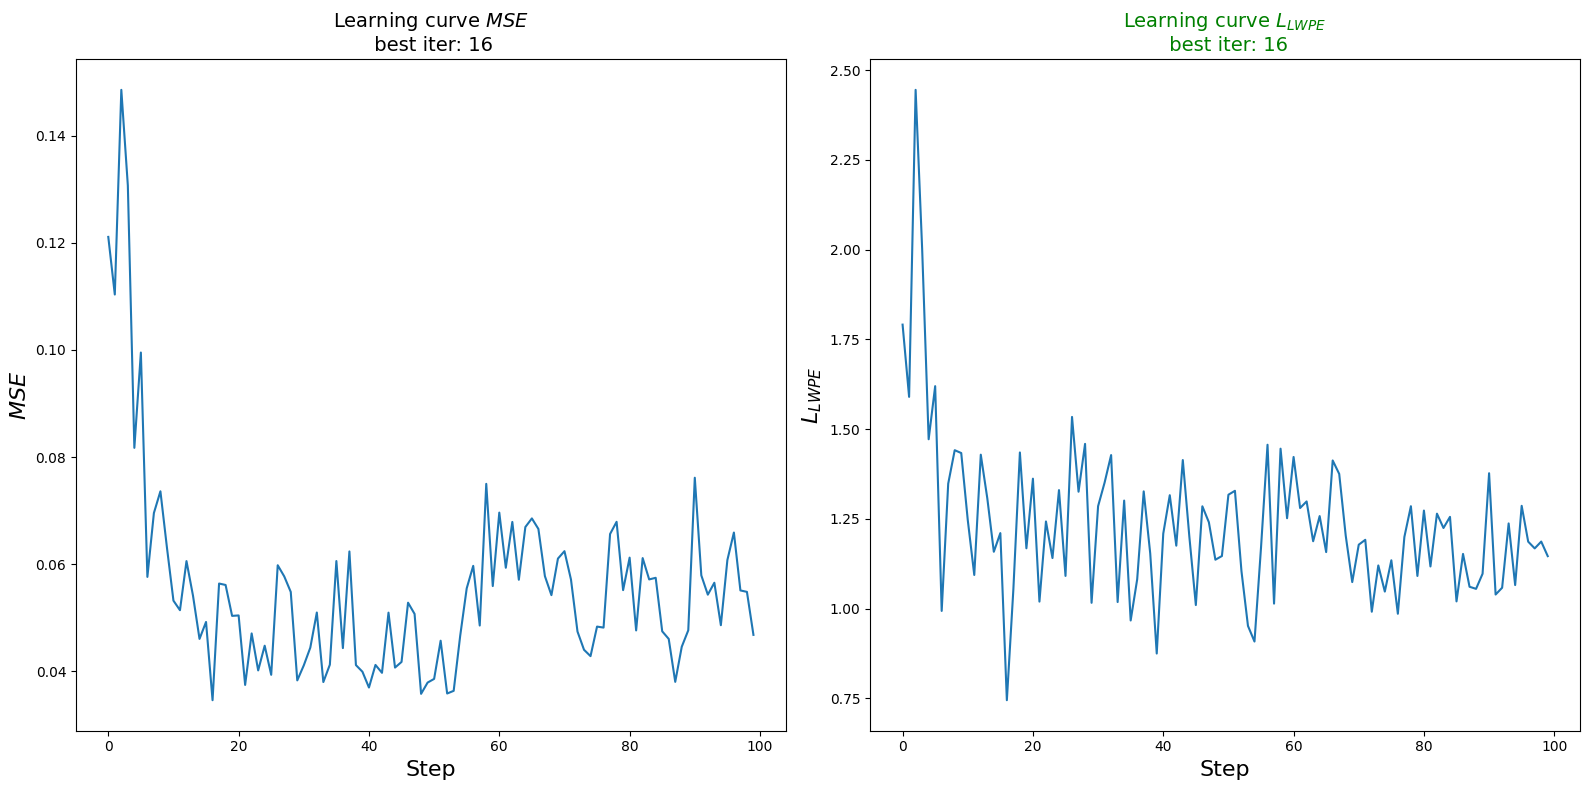

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


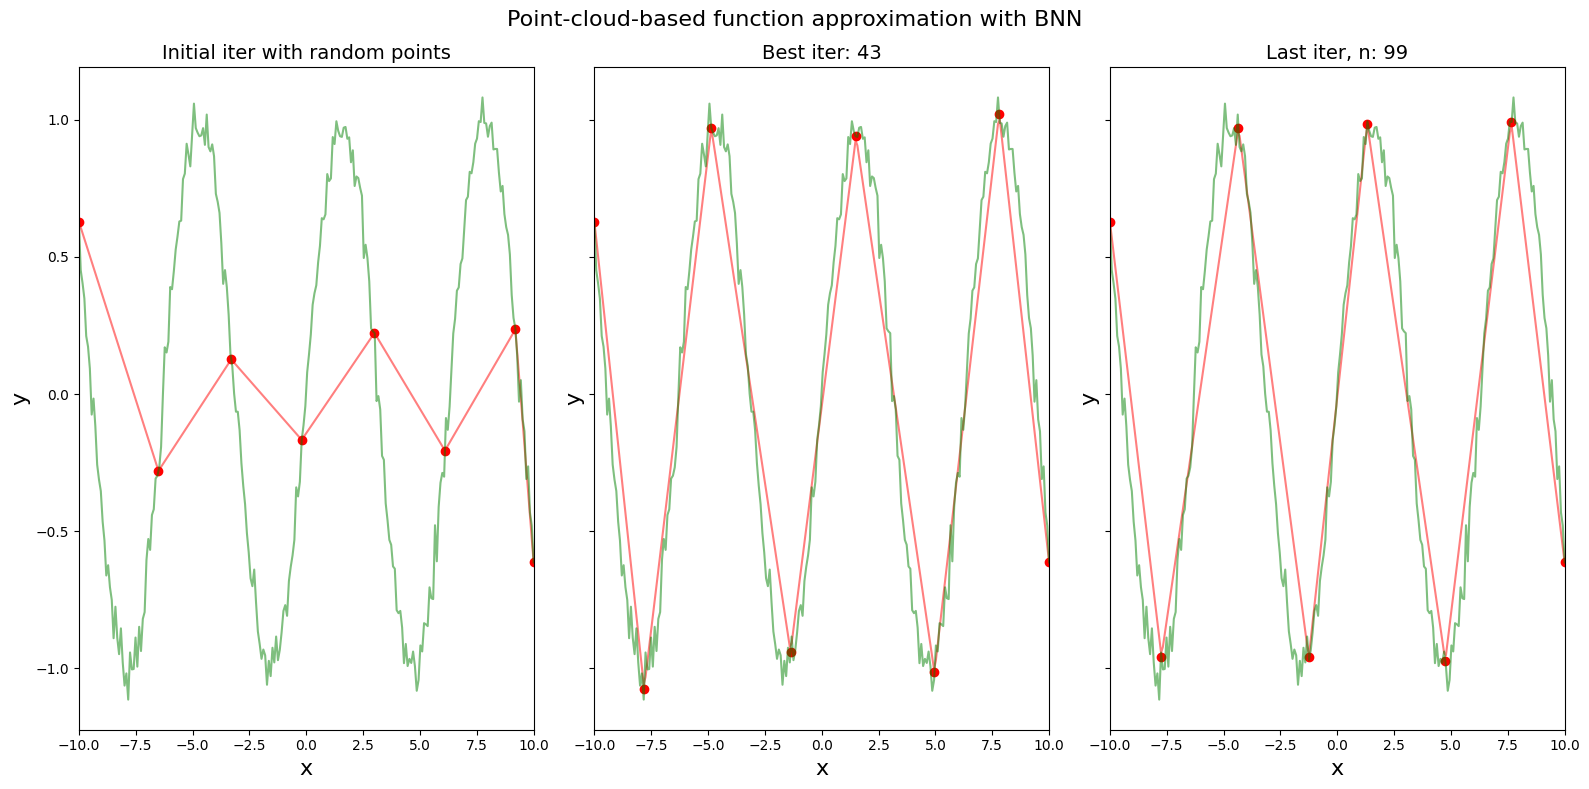

In [ ]:
num_points=250
function=np.sin
x_train, y_train = generate_training_data(function, (domain[0], domain[1]), num_points)
np.random.seed(7)
ruido = np.random.normal(0, 0.05, size=x_train.shape)
y_train = y_train + ruido
x_train = tf.constant(x_train,dtype=tf.float32)
y_train = tf.constant(y_train,dtype=tf.float32)

stbase = gd.SimplexTree()
for i in range(num_points-1):
    stbase.insert([i,i+1], -1e10) # aqui definimos que cada elemento esta conectado com su siguiente, ya que lo que tenemos es una linea, una serie temporal
layer = LowerStarLayer(simplextree=stbase)

dgmsRef = layer.call(tf.Variable(y_train))
dgmRef = dgmsRef[0][0]
PERef=persistent_entropy(dgmRef)
LWPERef=length_weighted_persistent_entropy(dgmRef)

mask = dgmRef[:,1] >= dgmRef[:,0] + 0.5
dgmRefFilt = dgmRef[mask]
PERefFilt=persistent_entropy(dgmRefFilt)
PERefFiltLim=length_weighted_persistent_entropy(dgmRefFilt)

x_points = tf.Variable([-10,-6.5,-3.3,-0.2,3.,6.1,9.2,10], dtype=tf.float32 ,trainable=True)
num_points_aprox = x_points.shape[0]

min_diff_entropy = float('inf')
num_iter = 100  
best_iter = 0

metricas = {
    "$MSE$": [],
    "$L_{LWPE}$": [],
}

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

for epoch in tqdm(range(num_iter)):
    with tf.GradientTape() as tape:
        tape.watch(x_points)
        y_points = interpolation_tf(x_train,y_train, x_points)
        points = tf.stack([x_points,y_points],axis=1)
        model = BaricentricNetwork(points)
        y_aprox = model(tf.expand_dims(x_train,axis=1))
        dgmsAprox = layer.call(y_aprox)
        dgmAprox = dgmsAprox[0][0]
        lossFunction = LengthWeightedPersistentEntropyLoss()
        entropyLoss = lossFunction(dgmRefFilt,dgmAprox)

    
    dgmsAprox = layer.call(y_aprox)
    dgmAprox = dgmsAprox[0][0]
    PEAproxActual=persistent_entropy(dgmAprox)
    LWPEAproxActual=length_weighted_persistent_entropy(dgmAprox)
    
    
    metricas["$L_{LWPE}$"].append(entropyLoss.numpy().item())


    gradients = tape.gradient(entropyLoss,[x_points])
    gradients[0] = tf.tensor_scatter_nd_update(gradients[0], [[0], [num_points_aprox - 1]], [0.0, 0.0]) # we keep constant the two extrema points

    mseActual = mse_fn(y_train,y_aprox)
    metricas["$MSE$"].append(mseActual.numpy().item())
    
    if epoch == 0:
        initial_model = model
        initial_x_points = tf.identity(x_points)
        initial_y_points = tf.identity(y_points)
        initial_PE = PEAproxActual
        initial_LWPE = LWPEAproxActual

    
    if entropyLoss < min_diff_entropy:
        min_diff_entropy = entropyLoss
        no_improvement_counter = 0
        best_x_points = tf.identity(x_points)
        best_y_points = tf.identity(y_points)
        best_model = model
        best_iter = epoch
        best_PE = PEAproxActual
        best_LWPE = LWPEAproxActual
    

    if epoch < num_iter - 1:
        optimizer.apply_gradients(zip(gradients, [x_points]))
        PEAproxPrevio = PEAproxActual
        msePrevio = mseActual
    else:
        last_model = model
        last_x_points = tf.identity(x_points)
        last_y_points = tf.identity(y_points)
        last_PE = PEAproxActual
        last_LWPE = LWPEAproxActual
        

metricasLWPE_noise_badinit  = metricas.copy()

fig, axs = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
axs[0].plot(x_train, initial_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(initial_PE.numpy().item(),6)}$', alpha=0.5)
axs[0].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[0].scatter(initial_x_points, initial_y_points, color="red", label="BNN Points creation")
axs[0].set_xlabel('x', fontsize=fontsize)
axs[0].set_ylabel('y', fontsize=fontsize)
axs[0].set_xlim((domain[0],domain[1]))
axs[0].set_title(f'Initial iter with random points',fontsize=14)
# axs[0].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[1].plot(x_train, best_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(best_PE.numpy().item(),6)}$', alpha=0.5)
axs[1].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[1].scatter(best_x_points, best_y_points, color="red", label="BNN Points creation")
axs[1].set_xlabel('x', fontsize=fontsize)
axs[1].set_ylabel('y', fontsize=fontsize)
axs[1].set_xlim((domain[0],domain[1]))
axs[1].set_title(f'Best iter: {best_iter}',fontsize=14)
# axs[1].legend(loc="lower left",fontsize=12, framealpha=0.5)
axs[2].plot(x_train, last_model(tf.expand_dims(x_train,axis=1)), 'r-', label=f'$BNN(x), PE(BNN(x)) = {np.round(last_PE.numpy().item(),6)}$', alpha=0.5)
axs[2].plot(x_train, y_train, 'g-', label=f'$f(x), PE(f(x)) = {np.round(PERef.numpy().item(),6)}$', alpha=0.5)
axs[2].scatter(last_x_points, last_y_points, color="red", label="BNN Points creation")
axs[2].set_xlabel('x', fontsize=fontsize)
axs[2].set_ylabel('y', fontsize=fontsize)
axs[2].set_xlim((domain[0],domain[1]))
axs[2].set_title(f'Last iter, n: {num_iter-1}',fontsize=14)
# axs[2].legend(loc="lower left",fontsize=12, framealpha=0.5)
plt.suptitle("Point-cloud-based function approximation with BNN",fontsize=16)
plt.savefig('figures/WithNoiseUnknownFunction_LWPELoss_BadInit.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

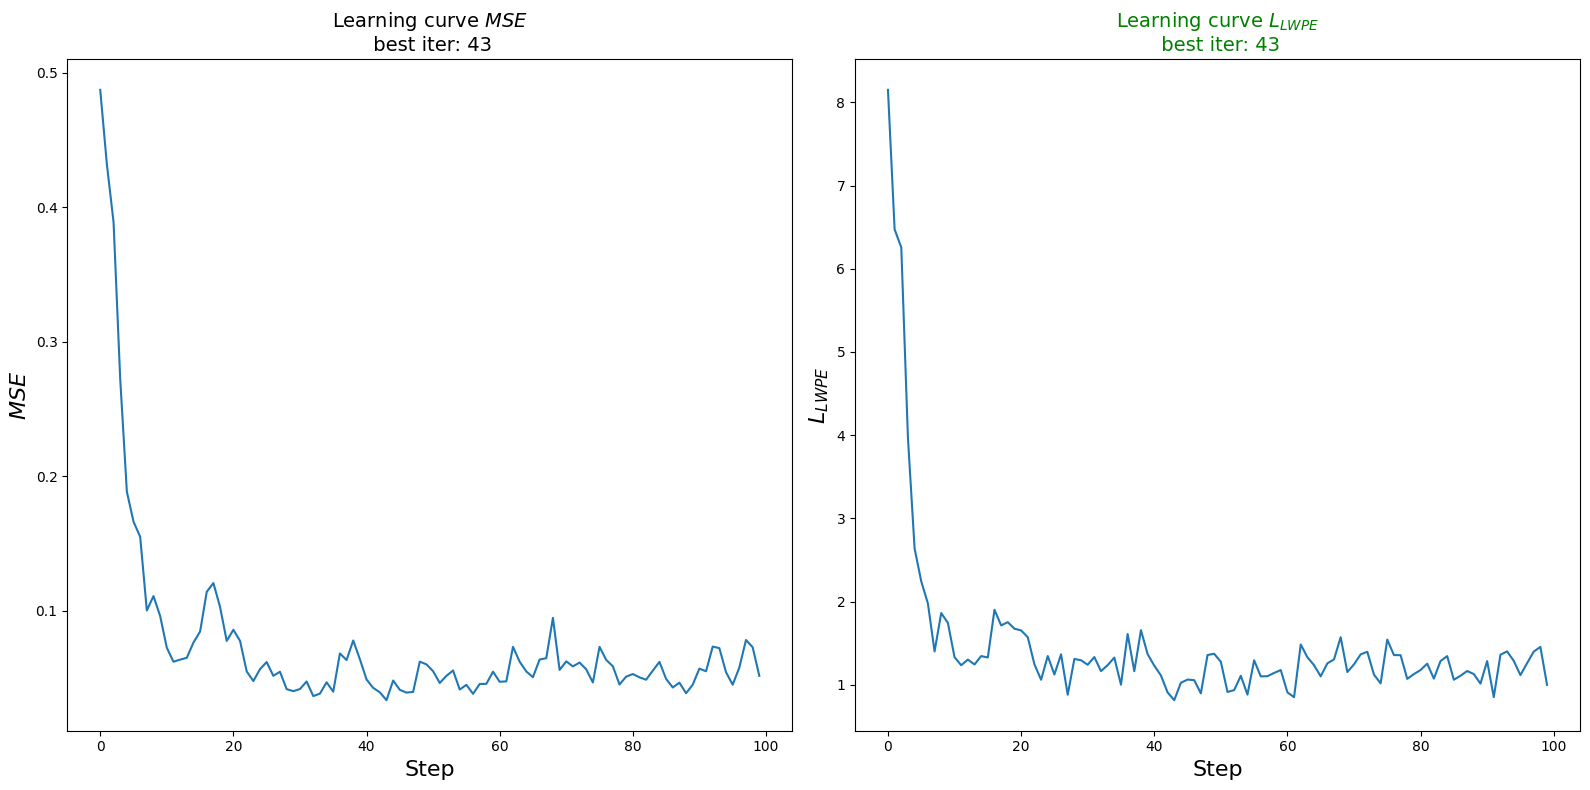

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()

for num, (nombre, metrica) in enumerate(metricas.items(),start=0):
    plt.sca(axes[num])
    plt.plot(metrica)
    color = "green" if num == 1 else "black"
    plt.title(f"Learning curve {nombre} \n best iter: {np.argmin(metrica)}", color = color)
    plt.xlabel("Step")
    plt.ylabel(f"{nombre}")
plt.tight_layout()        
plt.show()

## Comparing learning curves MSE and $L_{LWPE}$

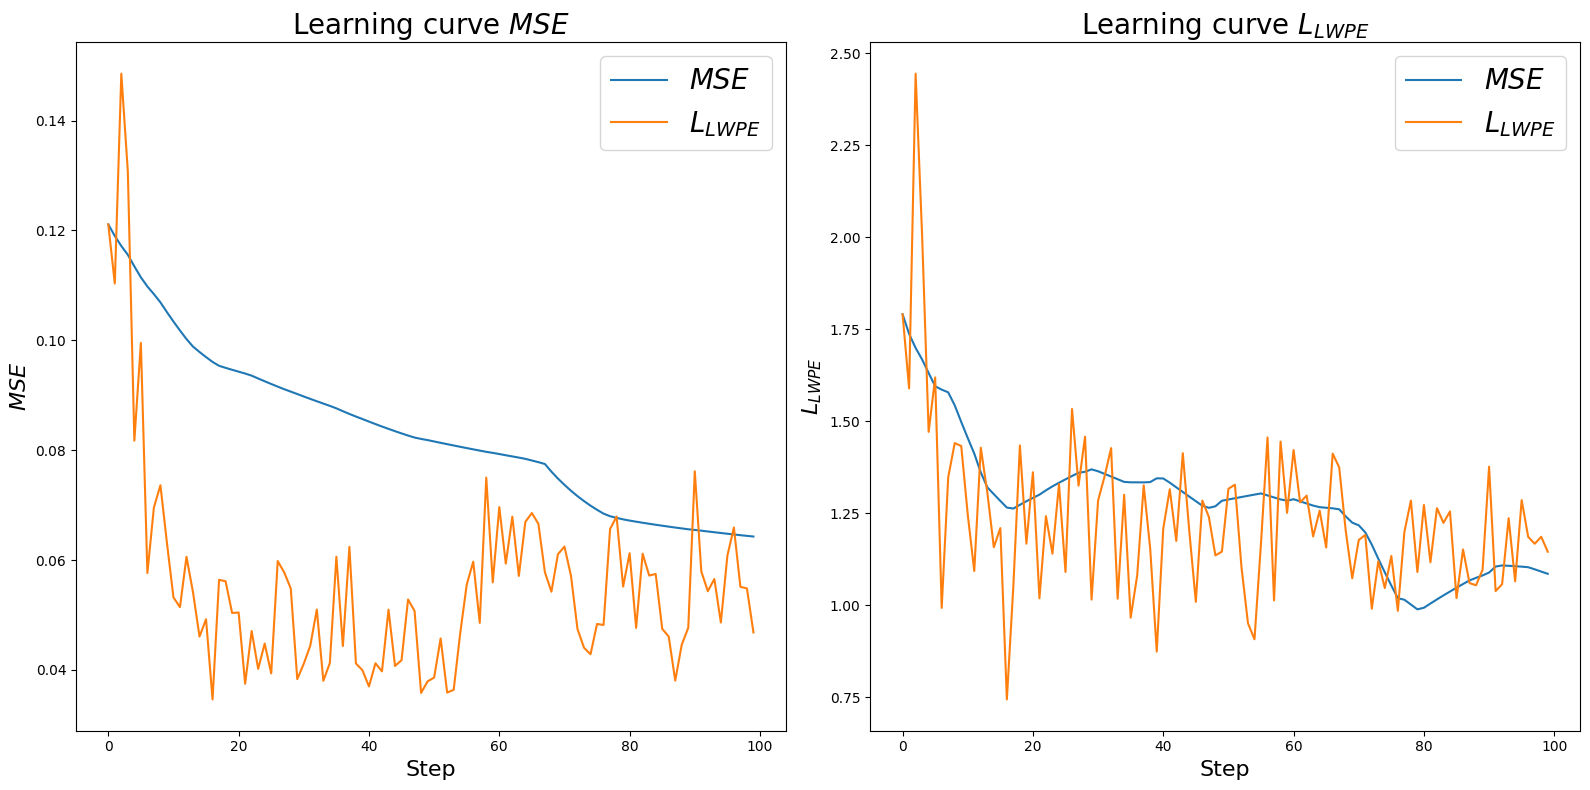

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{LWPE}$"]
for i, metric in enumerate([metricasMSE_noise_goodinit, metricasLWPE_noise_goodinit]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_WithNoiseUnknownFunction_BadInit.png', dpi=300, bbox_inches='tight')
plt.show()

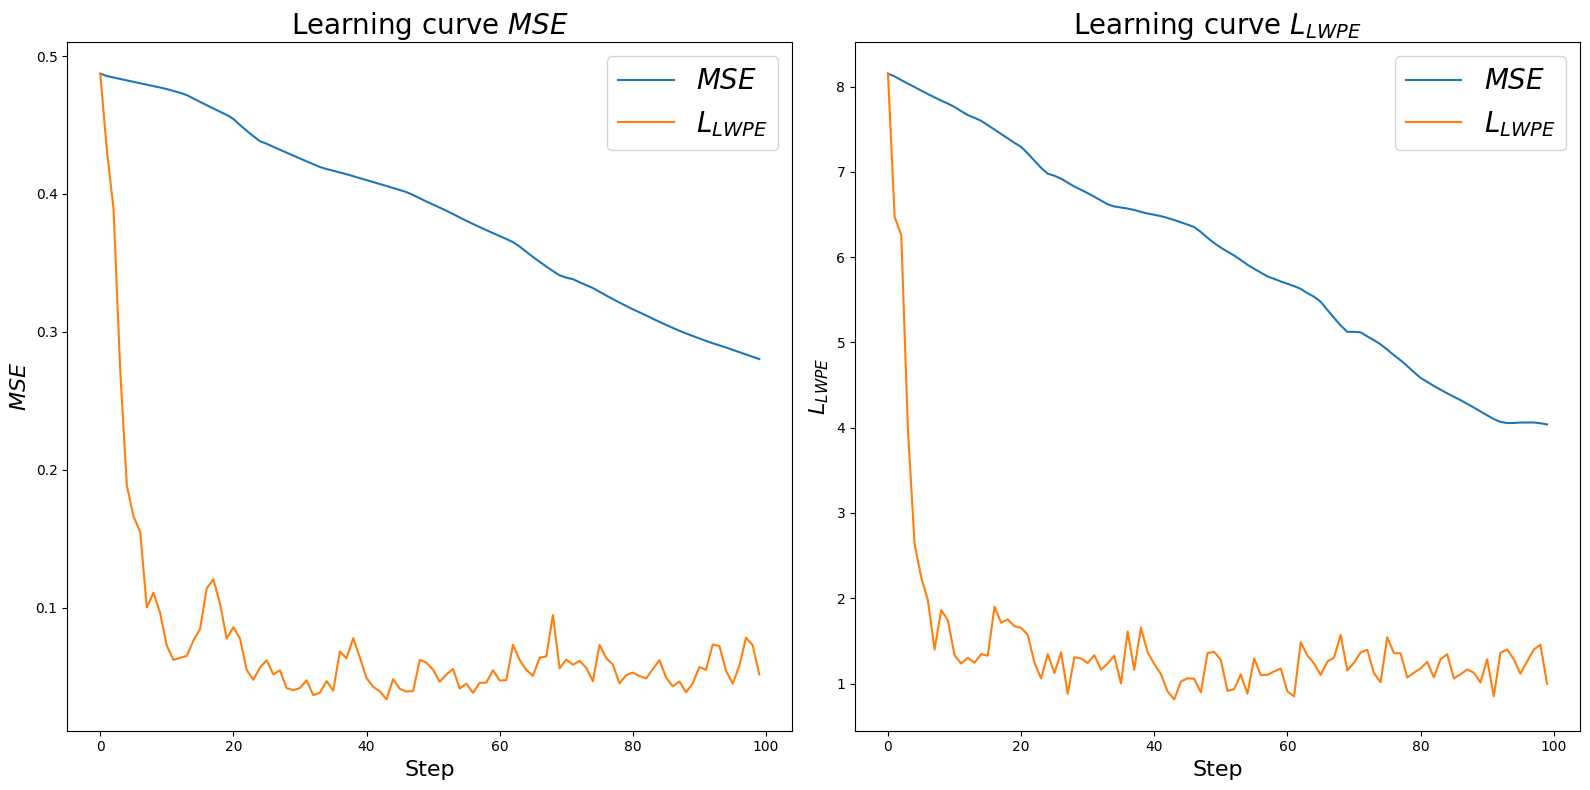

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
axes = axes.flatten()
labels = ["$MSE$","$L_{LWPE}$"]
for i, metric in enumerate([metricasMSE_noise_badinit, metricasLWPE_noise_badinit]):
    for num, (nombre, metrica) in enumerate(metric.items(),start=0):
        plt.sca(axes[num])
        plt.plot(metrica,label=labels[i])
        plt.title(f"Learning curve {nombre}",fontsize=20)
        plt.xlabel("Step")
        plt.ylabel(f"{nombre}")
        plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('figures/LearningCurves_WithNoiseUnknownFunction_BadInit.png', dpi=300, bbox_inches='tight')